#Image Caption Generator CNN + LSTM

In [1]:
import os
img_folder = "/content/drive/MyDrive/Flickr/Flicker8k_Dataset"
caption_file = "/content/drive/MyDrive/Flickr/Caption_data/Flickr8k.token.txt"

jpgs = os.listdir(img_folder)


In [2]:
import pandas as pd
from collections import Counter
import numpy as np

## read in the Flickr caption data
file = open(caption_file,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


In [3]:
df_txt.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


#Preprocessing Dataset

In [4]:

import string
def remove_punctuation(text_original):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punctuation = text_original.translate(translator)
    return text_no_punctuation


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)



def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


In [5]:
df_txt.tail(5)

,filename,index,caption
40450,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .
40454,997722733_0cb5439472.jpg,4,a rock climber practices on a rock climbing wa...


In [6]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [7]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = '<start> ' + txt + ' <end>'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [8]:
df_txt0.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,<start> child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,<start> girl going into wooden building <end>
2,1000268201_693b08cb0e.jpg,2,<start> little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,<start> little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,<start> little girl in pink dress going into ...


#Loading Pretrained CNN Model (Commented this code as it requires loading model weights)

In [20]:
#from keras.applications import VGG16

#modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights
#modelvgg.load_weights("/content/drive/MyDrive/Flickr/output/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
#modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
#Removing last layer as we need features
#from keras import models
#modelvgg.layers.pop()
#modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)

#modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Converting Image to feature vector and stroing in ordered dicitonary
#from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from collections import OrderedDict

#images = OrderedDict()
#npix = 224
#target_size = (npix,npix,3)
#data = np.zeros((len(jpgs),npix,npix,3))
#for i,name in enumerate(jpgs):
    # load an image from file
#    filename = img_folder + '/' + name
#    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
#    image = img_to_array(image)
#    nimage = preprocess_input(image)

#    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
#    images[name] = y_pred.flatten()

#Load feature vector images

In [9]:
import pickle

#with open('/content/drive/MyDrive/Flickr/output/images_features.pkl', 'wb') as f:
#    pickle.dump(images, f)

#loading feature vectors
with open('/content/drive/MyDrive/Flickr/output/images_features.pkl', 'rb') as f:
  images = pickle.load(f)

In [10]:
# Get the first image's features from the dictionary
first_image_name, first_image_tensor = next(iter(images.items()))

# Print the shape of the tensor
print(f"Shape of the tensor for {first_image_name}: {first_image_tensor.shape}")


Shape of the tensor for 3751594676_edfbfa0688.jpg: (4096,)


In [11]:
#Keep only one index

dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [12]:
#Change character vector to integer
from keras.preprocessing.text import Tokenizer

nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


vocabulary size : 4474
[[2, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2349, 522, 1], [2, 12, 8, 5, 751, 8, 17, 368, 1], [2, 48, 15, 170, 3, 583, 101, 3, 41, 9, 551, 1197, 11, 55, 213, 3, 1075, 1], [2, 10, 620, 6, 150, 27, 23, 8, 101, 46, 112, 1], [2, 10, 3, 24, 82, 96, 1198, 19, 162, 1]]


In [13]:
size_test, size_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*size_test), int(N*size_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [14]:
maxlen = np.max([len(text) for text in dtexts])

In [15]:
print(maxlen)

30


In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4474)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4474)


In [22]:
#LSTM
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4474
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 64)               286336    ['input_5[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 CaptionFeature (LSTM)       (None, 256)                  328704    ['embedding_1[0][0]']         
                                                                                       

In [ ]:
import sys, time, os, warnings
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                  epochs=25, verbose=1,
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/25
776/776 [==============================] - 69s 81ms/step - loss: 5.3342 - val_loss: 4.8059
Epoch 2/25
776/776 [==============================] - 48s 62ms/step - loss: 4.3629 - val_loss: 4.4825
Epoch 3/25
776/776 [==============================] - 47s 61ms/step - loss: 3.8782 - val_loss: 4.4177
Epoch 4/25
776/776 [==============================] - 47s 61ms/step - loss: 3.5407 - val_loss: 4.4193
Epoch 5/25
776/776 [==============================] - 47s 61ms/step - loss: 3.2676 - val_loss: 4.5039
Epoch 6/25
776/776 [==============================] - 47s 61ms/step - loss: 3.0114 - val_loss: 4.7345
Epoch 7/25
776/776 [==============================] - 47s 61ms/step - loss: 2.7737 - val_loss: 5.0015
Epoch 8/25
776/776 [==============================] - 47s 61ms/step - loss: 2.5564 - val_loss: 5.2765
Epoch 9/25
776/776 [==============================] - 47s 61ms/step - loss: 2.3429 - val_loss: 5.4712
Epoch 10/25
776/776 [==============================] - 47s 60ms/step - loss: 2.161

This is not my final result graph as I was training and testing with different hyperparameters.

In [18]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4474)


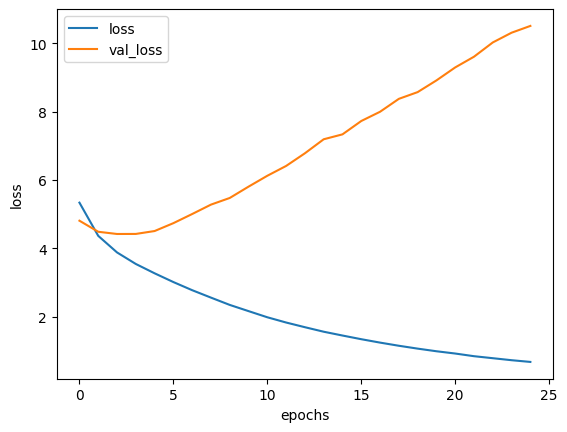

In [ ]:
import matplotlib.pyplot as plt
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Flickr/output/my_model1.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Load Trained Model

In [25]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Flickr/output/my_model1.h5')
#model = load_model('/content/drive/MyDrive/Flickr/output/my_25epochs.h5')

# Test 3 images

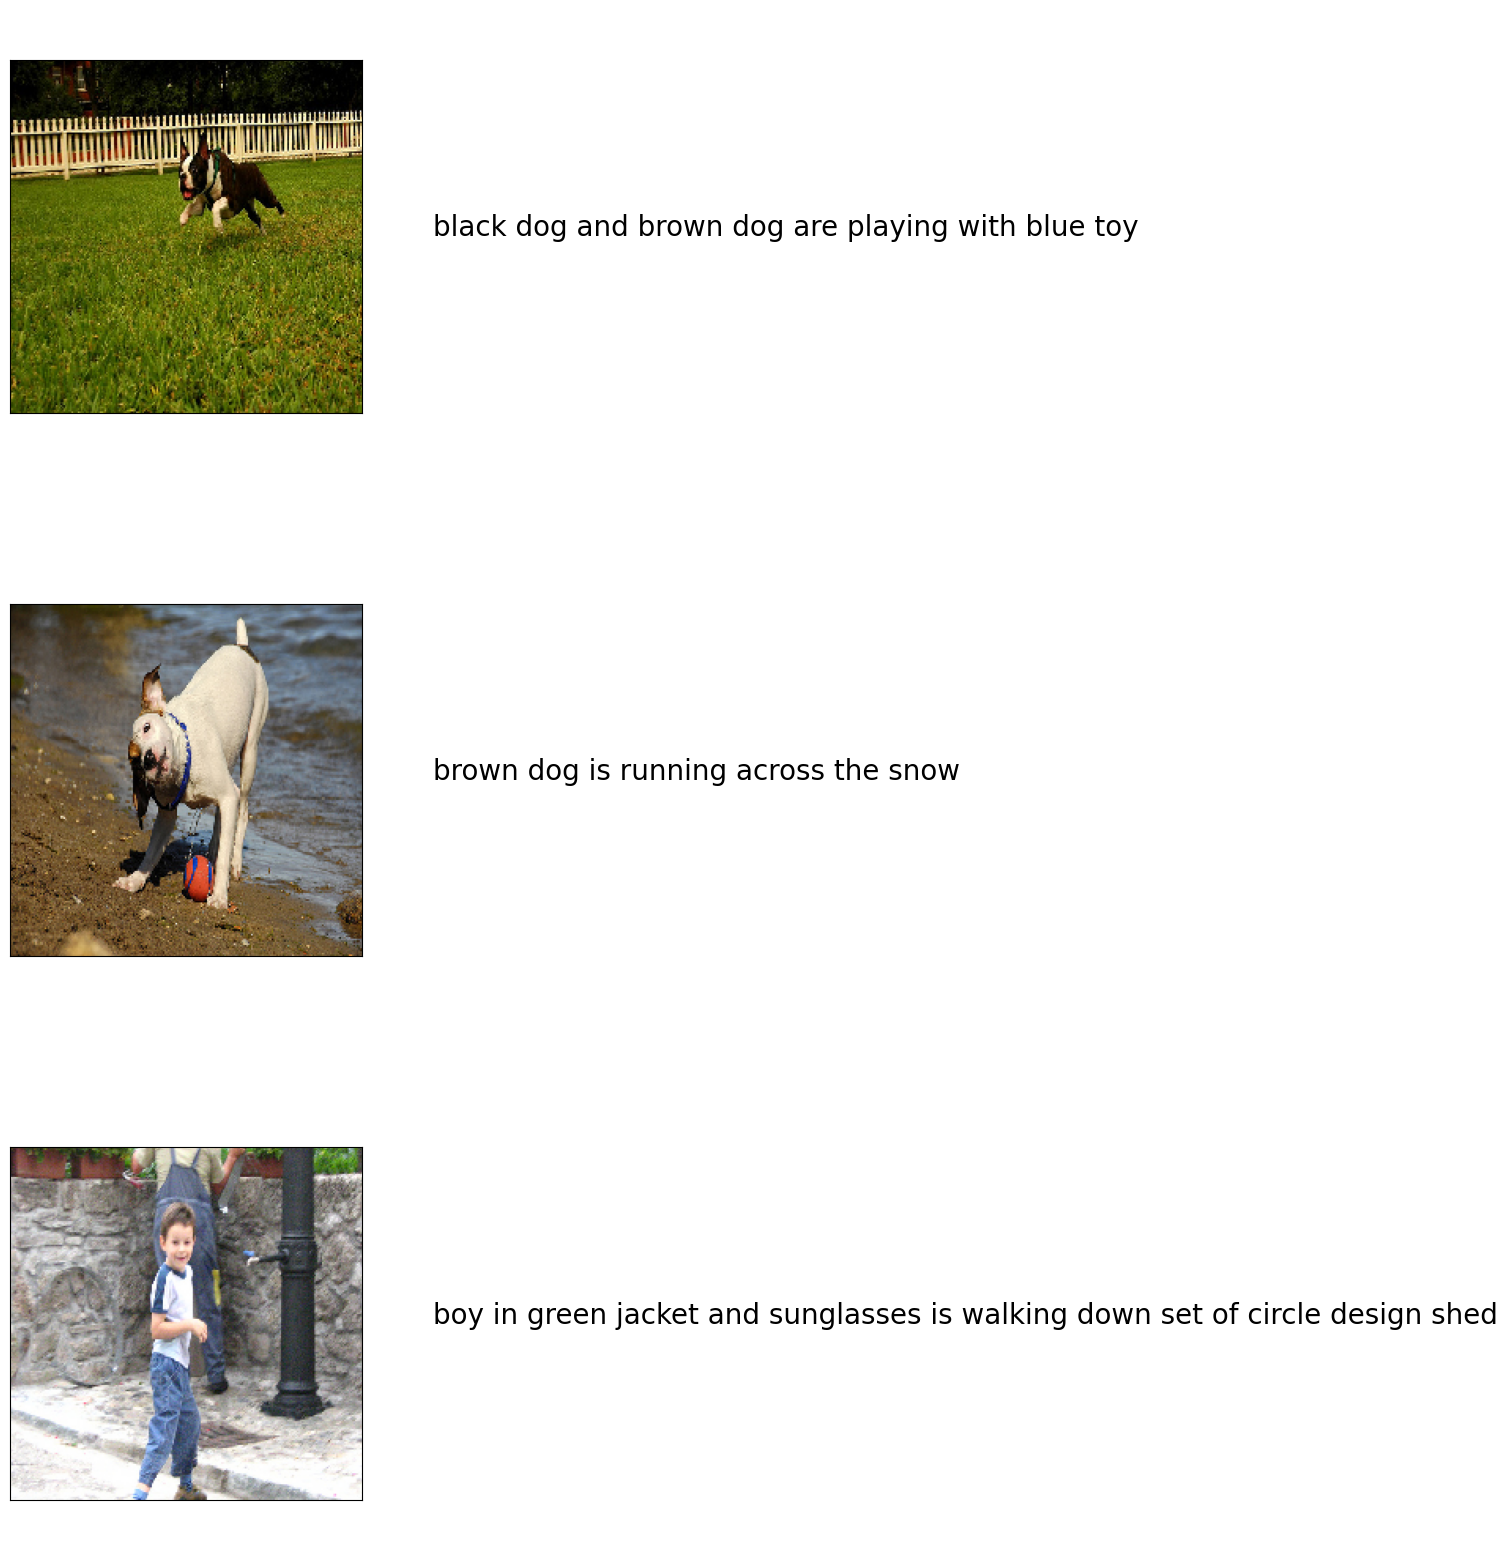

In [27]:
from keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption1(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = '<start>'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "<end>" or newword == "end":
            break
    words = in_text.split()
    if len(words) > 2:
        in_text = ' '.join(words[1:-1])
    else:
        in_text = ""

    return in_text





npic = 3
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[6:9],di_test[6:9]):
    ## images
    filename = img_folder + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption1(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [26]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

#Calculate BLEU Score for Test Images

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

all_bleu_scores = []
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):

    original_caption = ' '.join([index_word.get(i, '') for i in tokenized_text if i not in [0]]).replace('start', '').replace('end', '').strip()
    predicted_caption = predict_caption1(image_feature.reshape(1, -1))
    bleu_score = sentence_bleu([original_caption.split()], predicted_caption.split(),weights=(1, 0, 0, 0))
    all_bleu_scores.append(bleu_score)

# Calculate the average BLEU score across all test images
average_bleu_score = np.mean(all_bleu_scores)
print(f"Average BLEU Score: {average_bleu_score:.2f}")


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU Score: 0.16


In [ ]:
#Save BLEU Score
#with open('/content/drive/MyDrive/Flickr/final_1gram_images.txt', 'w') as file:
#    for score in all_bleu_scores:
#        file.write(f"{score}\n")


In [ ]:
import pandas as pd
import numpy as np
df_files = pd.read_csv('/content/drive/MyDrive/Flickr/final_1gram_images.txt')

In [ ]:
del df_files

In [ ]:
#import csv

#with open('/content/drive/MyDrive/Flickr/final_1_gram_images.csv', 'w', newline='') as csvfile:
#    writer = csv.writer(csvfile)
#    writer.writerow(['Filename', 'BLEU Score'])
#    for jpgfnm, score in zip(fnm_test, all_bleu_scores):
#        writer.writerow([jpgfnm, score])


In [21]:
import pandas as pd
import numpy as np
df_files = pd.read_csv('/content/drive/MyDrive/Flickr/final_1_gram_images.csv')

In [22]:
df_files.head()

,Filename,BLEU Score
0,1000268201_693b08cb0e.jpg,0.000000
1,1001773457_577c3a7d70.jpg,0.142857
2,1002674143_1b742ab4b8.jpg,0.078987
3,1003163366_44323f5815.jpg,0.000000
4,1007129816_e794419615.jpg,0.333333


In [23]:
np.mean(df_files['BLEU Score'])

0.1574738452693478

In [24]:
import pandas as pd



# Sorting the DataFrame by 'bleu_score' in descending order while keeping the original index
sorted_df = df_files.sort_values(by='BLEU Score', ascending=False)

# Getting the top 3 rows after sorting
top_3 = sorted_df.tail(3)

# Extracting filenames and their original indices
top_3_filenames = top_3['Filename'].tolist()
top_3_indices = top_3.index.tolist()

print("Top 3 filenames:", top_3_filenames)
print("Original indices of top 3:", top_3_indices)


Top 3 filenames: ['1956944011_c5661d3f22.jpg', '1947351225_288d788983.jpg', '2355880294_8f78a6fea6.jpg']
Original indices of top 3: [803, 799, 1617]


#Files with highest BLEU Score

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


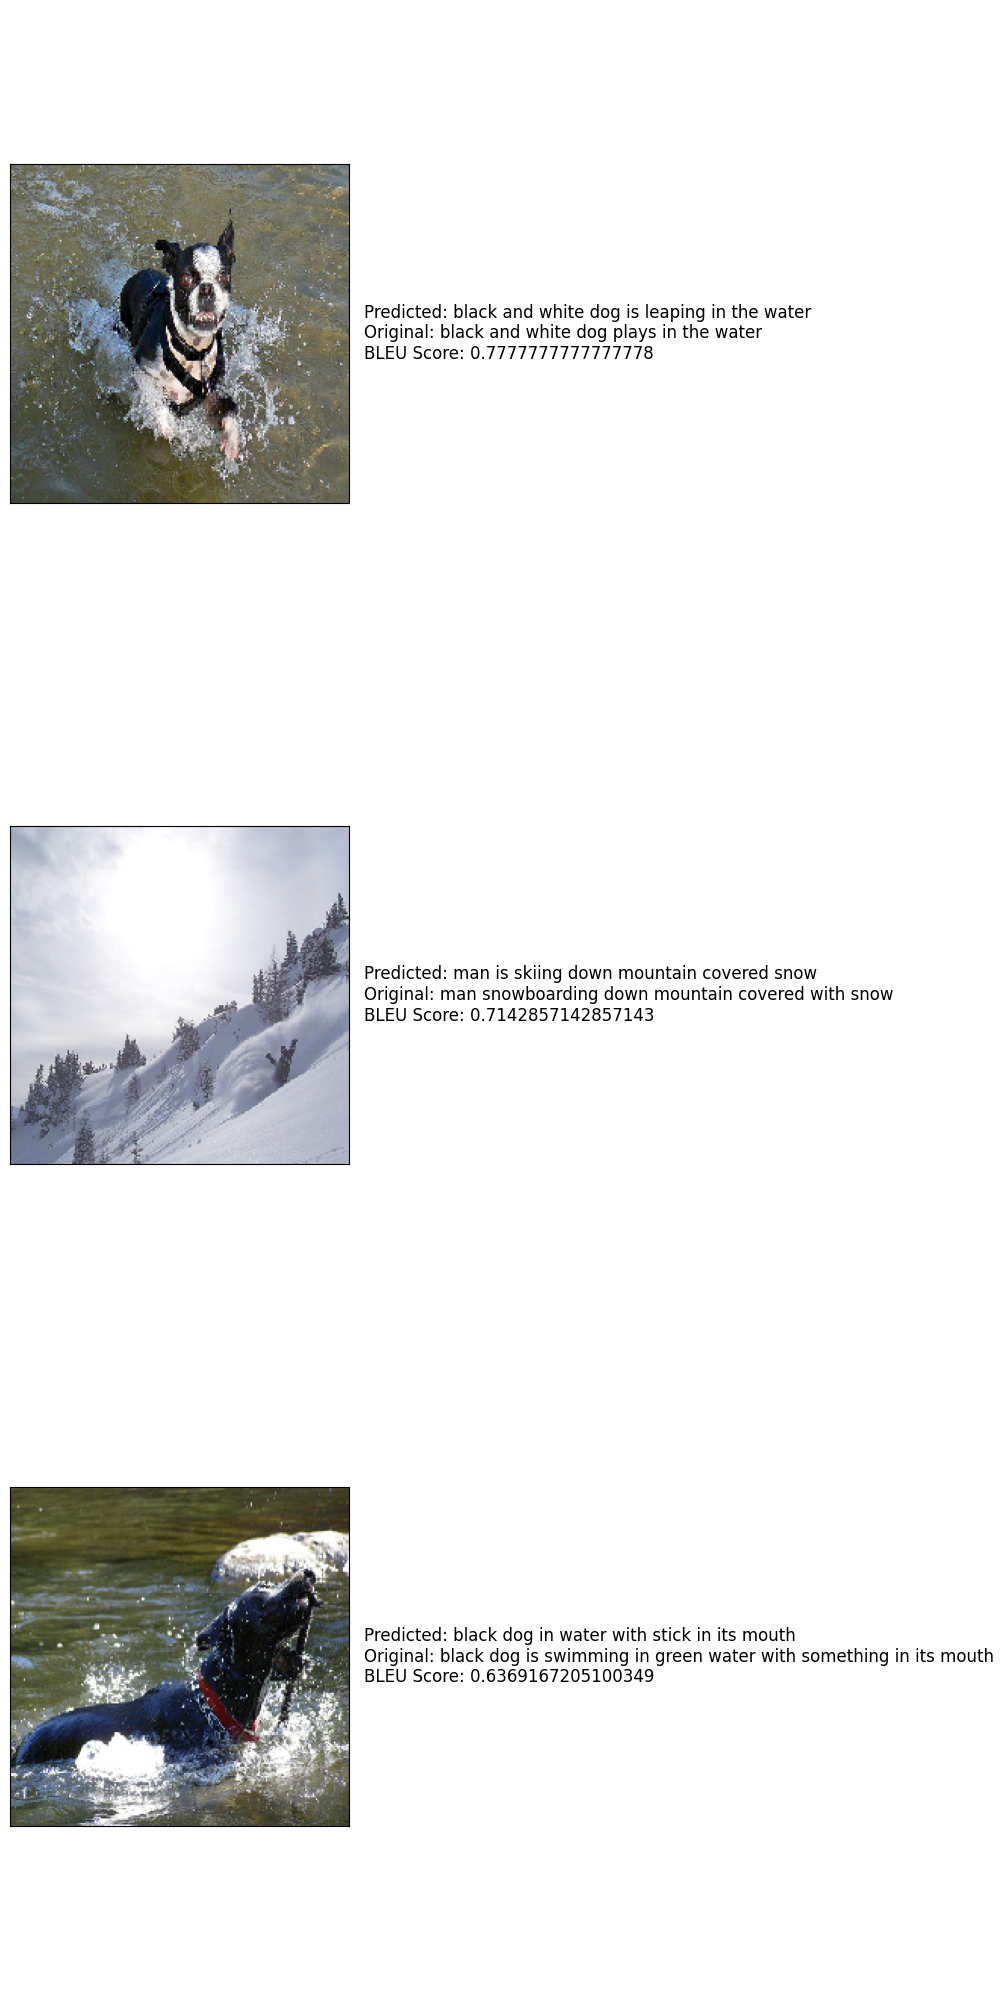

In [25]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu


top_3_filenames = ['1772859261_236c09b861.jpg', '2065309381_705b774f51.jpg', '1465666502_de289b3b9c.jpg']
top_3_indices = [697, 898, 501]  # These need to match indices in `dt_test` for original captions

npix = 224
target_size = (npix, npix, 3)

fig = plt.figure(figsize=(10, 20))
for i, (filename, index) in enumerate(zip(top_3_filenames, top_3_indices), start=1):
    full_path = f"{img_folder}/{filename}"
    image_load = load_img(full_path, target_size=target_size)

    # Display the image
    ax = fig.add_subplot(len(top_3_filenames), 2, 2*i-1, xticks=[], yticks=[])
    ax.imshow(image_load)

    # Predict the caption
    image_feature = di_test[index]  # Make sure di_test is correctly indexed
    caption_predicted = predict_caption1(image_feature.reshape(1, -1))

    # Get the original caption
    tokenized_text = dt_test[index]  # Assuming dt_test is correctly indexed
    original_caption = ' '.join([index_word.get(i, '') for i in tokenized_text if i not in [0]]).replace('start', '').replace('end', '').strip()
    bleu_score = sentence_bleu([original_caption.split()], caption_predicted.split(),weights=(1, 0, 0, 0))

    # Display both captions
    ax = fig.add_subplot(len(top_3_filenames), 2, 2*i)
    plt.axis('off')
    caption_text = f"Predicted: {caption_predicted}\nOriginal: {original_caption}\nBLEU Score: {bleu_score}"
    ax.text(0, 0.5, caption_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()


#Files with Lowest BLEU Score

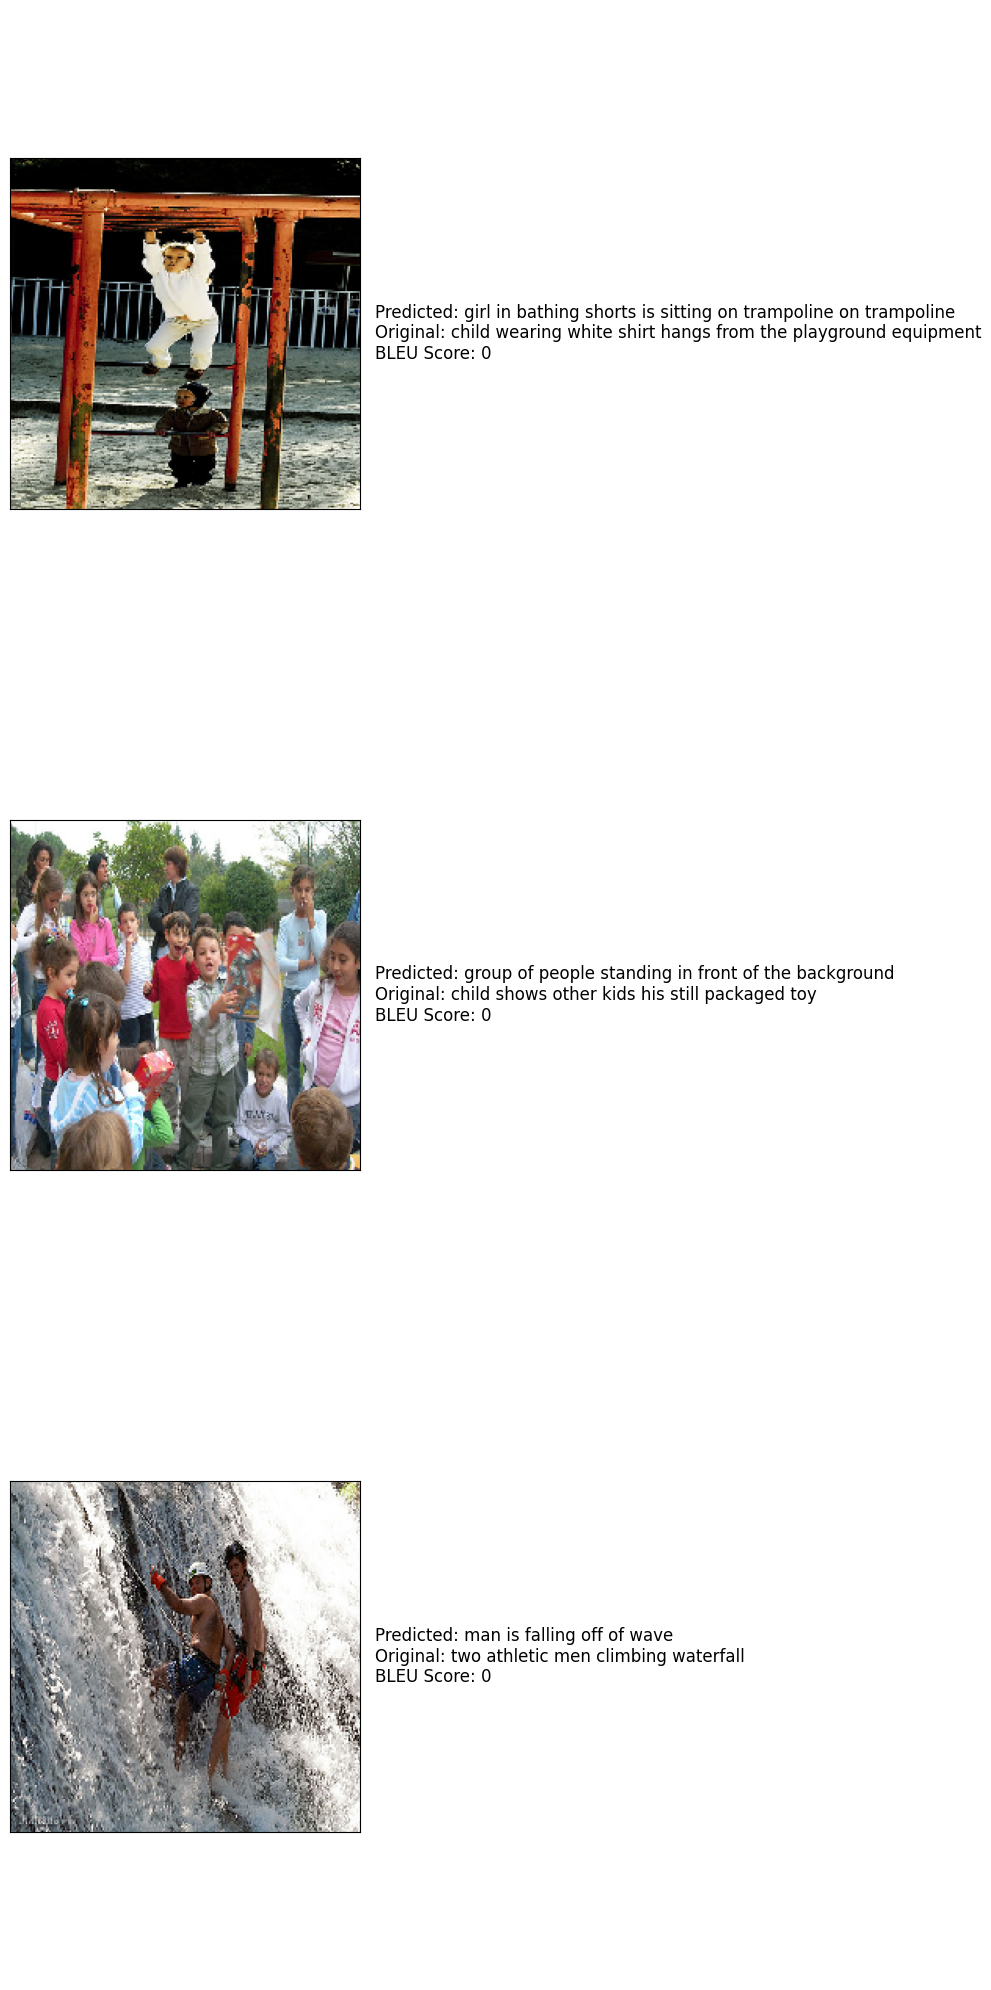

In [26]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

# Assuming the rest of the setup is the same (tokenizer, model, index_word, img_folder)
top_3_filenames = ['1956944011_c5661d3f22.jpg', '1947351225_288d788983.jpg', '2355880294_8f78a6fea6.jpg']
top_3_indices = [803, 799, 1617]  # These need to match indices in `dt_test` for original captions

npix = 224
target_size = (npix, npix, 3)

fig = plt.figure(figsize=(10, 20))
for i, (filename, index) in enumerate(zip(top_3_filenames, top_3_indices), start=1):
    full_path = f"{img_folder}/{filename}"
    image_load = load_img(full_path, target_size=target_size)

    # Display the image
    ax = fig.add_subplot(len(top_3_filenames), 2, 2*i-1, xticks=[], yticks=[])
    ax.imshow(image_load)

    # Predict the caption
    image_feature = di_test[index]  # Make sure di_test is correctly indexed
    caption_predicted = predict_caption1(image_feature.reshape(1, -1))

    # Get the original caption
    tokenized_text = dt_test[index]  # Assuming dt_test is correctly indexed
    original_caption = ' '.join([index_word.get(i, '') for i in tokenized_text if i not in [0]]).replace('start', '').replace('end', '').strip()
    bleu_score = sentence_bleu([original_caption.split()], caption_predicted.split(),weights=(1, 0, 0, 0))

    # Display both captions
    ax = fig.add_subplot(len(top_3_filenames), 2, 2*i)
    plt.axis('off')
    caption_text = f"Predicted: {caption_predicted}\nOriginal: {original_caption}\nBLEU Score: {bleu_score}"
    ax.text(0, 0.5, caption_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()
